In [1]:
#%pip install scikit-image

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from skimage.transform import estimate_transform

In [ ]:
# Function to extract regions from Excel file
def extract_regions(file_path, sheet_name=None):
    """Extracts separate DataFrames for each region from a column-based Excel format."""
    xls = pd.ExcelFile(file_path)
    df = pd.read_excel(xls, sheet_name=None, header=0)  # Ensure first row is treated as headers

    # Assume the first sheet has the data, otherwise use the specified sheet
    if sheet_name:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=0)
    else:
        df = pd.read_excel(xls, sheet_name=xls.sheet_names[0], header=0)

    # Clean column names (remove extra spaces)
    df.columns = df.columns.str.strip()

    regions = {}
    num_regions = df.shape[1] // 6  # Assuming each region has 6 columns

    for i in range(num_regions):
        start_col = i * 6
        cols = df.iloc[:, start_col:start_col + 6].dropna()
        cols.columns = ['Centroid_X', 'Centroid_Y', 'Avg_Red', 'Avg_Blue', 'Avg_Green', 'Total_Int_Avg']

        # Convert data to numeric, forcing errors to NaN and dropping them
        for col in ['Centroid_X', 'Centroid_Y', 'Total_Int_Avg']:
            cols[col] = pd.to_numeric(cols[col], errors='coerce')
        cols = cols.dropna()

        regions[f'Region {i+1}'] = cols[['Centroid_X', 'Centroid_Y', 'Total_Int_Avg']]

    return regions

# Function to match particles
# def match_particles(df1, df2, tolerance=1.0, use_transform=True):
#     """Matches particles between two DataFrames based on (x, y) coordinates."""
#     tree = cKDTree(df2[['Centroid_X', 'Centroid_Y']].values)
#     distances, indices = tree.query(df1[['Centroid_X', 'Centroid_Y']].values, distance_upper_bound=tolerance)
    
#     valid_matches = distances < tolerance
#     df1_matched = df1[valid_matches].reset_index(drop=True)
#     df2_matched = df2.iloc[indices[valid_matches]].reset_index(drop=True)
    
#     if use_transform and len(df1_matched) >= 3:
#         src_pts = df2_matched[['Centroid_X', 'Centroid_Y']].values
#         dst_pts = df1_matched[['Centroid_X', 'Centroid_Y']].values
#         transform = estimate_transform('affine', src_pts, dst_pts)
#         df2[['x_adj', 'y_adj']] = transform(df2[['Centroid_X', 'Centroid_Y']].values)
        
#         tree = cKDTree(df2[['x_adj', 'y_adj']].values)
#         distances, indices = tree.query(df1[['Centroid_X', 'Centroid_Y']].values, distance_upper_bound=tolerance)
#         valid_matches = distances < tolerance
#         df1_matched = df1[valid_matches].reset_index(drop=True)
#         df2_matched = df2.iloc[indices[valid_matches]].reset_index(drop=True).drop_duplicates()

    
#     matched_df = df1_matched[['Centroid_X', 'Centroid_Y']].copy()
#     matched_df['intensity_ratio'] = df1_matched['Total_Int_Avg'] / df2_matched['Total_Int_Avg']
    
#     num_matched = len(matched_df)
#     return matched_df, num_matched

def match_particles(df1, df2, tolerance=1.0, use_transform=True):
    """Matches particles between two DataFrames based on (x, y) coordinates."""
    tree = cKDTree(df2[['Centroid_X', 'Centroid_Y']].values)
    distances, indices = tree.query(df1[['Centroid_X', 'Centroid_Y']].values, distance_upper_bound=tolerance)

    # Ensure each df2 point is only matched once
    used_indices = set()
    filtered_indices = []
    filtered_df1 = []

    for i, idx in enumerate(indices):
        if distances[i] < tolerance and idx not in used_indices:
            used_indices.add(idx)
            filtered_indices.append(idx)
            filtered_df1.append(i)

    df1_matched = df1.iloc[filtered_df1].reset_index(drop=True)
    df2_matched = df2.iloc[filtered_indices].reset_index(drop=True)

    if use_transform and len(df1_matched) >= 3:
        src_pts = df2_matched[['Centroid_X', 'Centroid_Y']].values
        dst_pts = df1_matched[['Centroid_X', 'Centroid_Y']].values
        transform = estimate_transform('affine', src_pts, dst_pts)
        df2[['x_adj', 'y_adj']] = transform(df2[['Centroid_X', 'Centroid_Y']].values)

        tree = cKDTree(df2[['x_adj', 'y_adj']].values)
        distances, indices = tree.query(df1[['Centroid_X', 'Centroid_Y']].values, distance_upper_bound=tolerance)

        # Ensure each df2 point is only matched once after transformation
        used_indices.clear()
        filtered_indices = []
        filtered_df1 = []

        for i, idx in enumerate(indices):
            if distances[i] < tolerance and idx not in used_indices:
                used_indices.add(idx)
                filtered_indices.append(idx)
                filtered_df1.append(i)

        df1_matched = df1.iloc[filtered_df1].reset_index(drop=True)
        df2_matched = df2.iloc[filtered_indices].reset_index(drop=True)

    matched_df = df1_matched[['Centroid_X', 'Centroid_Y']].copy()
    matched_df['intensity_ratio'] = df1_matched['Total_Int_Avg'] / df2_matched['Total_Int_Avg']

    num_matched = len(matched_df)
    return matched_df, num_matched

In [ ]:
file1 = "....."
sheet1 = '.....'
file2 = "......"
regions1 = extract_regions(file1, sheet1)
regions2 = extract_regions(file2, sheet1)

for region in regions1.keys():
    if region in regions2:
        df1 = regions1[region]
        df2 = regions2[region]
        print(f"Region: {region} \n Entries in df1: {len(df1)}, Entries in df2: {len(df2)}")
        matched_df, num_matched = match_particles(regions1[region], regions2[region], tolerance=100.0)
        print(f"Matched particles: {num_matched}, Match % = {num_matched/min(len(df1), len(df2))*100:.2f}")
        print(f"Intensity ratio average = {np.mean(matched_df['intensity_ratio']):.3f}")
        print(matched_df.head())
        print("-" * 50)

Region: Region 1 
 Entries in df1: 703, Entries in df2: 691
Matched particles: 631, Match % = 91.32
Intensity ratio average = 0.970
    Centroid_X   Centroid_Y  intensity_ratio
0  2241.137856  1682.704338         0.975980
1   205.311644    13.308904         0.807204
2   571.724896    16.212305         1.184611
3   900.662450    11.596320         1.066976
4  1454.995052    20.659469         0.950219
--------------------------------------------------
Region: Region 2 
 Entries in df1: 636, Entries in df2: 610
Matched particles: 548, Match % = 89.84
Intensity ratio average = 0.962
    Centroid_X   Centroid_Y  intensity_ratio
0  2156.540965  1674.407627         0.317562
1  2565.593052    33.274178         1.105424
2  3177.411493    98.292526         0.980267
3  3522.722596    14.249847         0.844447
4  3837.741218    12.984778         0.974066
--------------------------------------------------
Region: Region 3 
 Entries in df1: 518, Entries in df2: 521
Matched particles: 472, Match % = 

In [ ]:
matched_regions = {}

for region in regions1.keys():
    if region in regions2:
        df1 = regions1[region]
        df2 = regions2[region]
        matched_df, num_matched = match_particles(df1, df2, tolerance=100.0)
        matched_regions[region] = matched_df

# Export all matched DataFrames into Excel 
output_file = f"matched_particles_{sheet1}.xlsx"

with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    all_regions = []
    
    for region, matched_df in matched_regions.items():
        matched_df = matched_df[['Centroid_X', 'Centroid_Y', 'Intensity_ratio']]
        
        all_regions.append(matched_df)
    
    final_df = pd.concat(all_regions, axis=1)
    
    # Write to an Excel file (single sheet)
    final_df.to_excel(writer, sheet_name='Matched Data', index=False)

print(f"Exported matched data to {output_file}")

Exported matched data to matched_particles_d_2.8V.xlsx


In [ ]:
output_file = f"matched_particles_{sheet1}.xlsx"

all_region_dfs = []

region_headers = []

for region, matched_df in matched_regions.items():
    matched_df = matched_df[['Centroid_X', 'Centroid_Y', 'intensity_ratio']]
    
    # Rename 'intensity_ratio' to 'Total_Int_Avg' for consistency
    matched_df = matched_df.rename(columns={'intensity_ratio': 'Total_Int_Avg'})
    
    # Add region name to the header list
    region_headers.extend([region, '', ''])  

    # Append formatted DataFrame to the list
    all_region_dfs.append(matched_df)

# Ensure all DataFrames have the same length by filling with NaNs where necessary
max_length = max(df.shape[0] for df in all_region_dfs)
all_region_dfs = [df.reindex(range(max_length)) for df in all_region_dfs]

final_df = pd.concat(all_region_dfs, axis=1)

# Insert the region names as the first row
header_df = pd.DataFrame([region_headers], columns=final_df.columns)

# Append actual data below the header row
final_df = pd.concat([header_df, final_df], ignore_index=True)

# Export to an Excel file
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    final_df.to_excel(writer, sheet_name='Matched Data', index=False, header=False)

print(f"Exported matched data to {output_file}")

Exported matched data to matched_particles_d_2.8V.xlsx


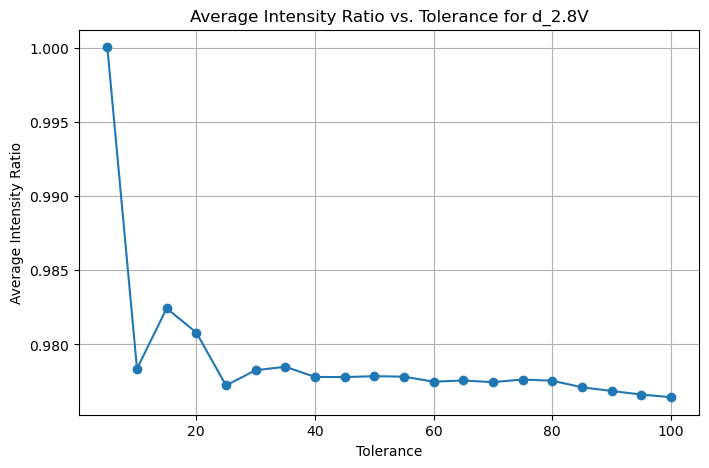

In [5]:
tolerances = np.linspace(5,100,20)

# Store results
tolerance_values = []
average_intensity_ratios = []

for tolerance in tolerances:
    total_intensity_ratios = []
    
    for region in regions1.keys():
        if region in regions2:
            df1 = regions1[region]
            df2 = regions2[region]
            
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                total_intensity_ratios.append(avg_intensity_ratio)

    if total_intensity_ratios:
        tolerance_values.append(tolerance)
        average_intensity_ratios.append(np.mean(total_intensity_ratios))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(tolerance_values, average_intensity_ratios, marker='o', linestyle='-')
plt.xlabel("Tolerance")
plt.ylabel("Average Intensity Ratio")
plt.title(f"Average Intensity Ratio vs. Tolerance for {sheet1}")
plt.grid()
plt.show()

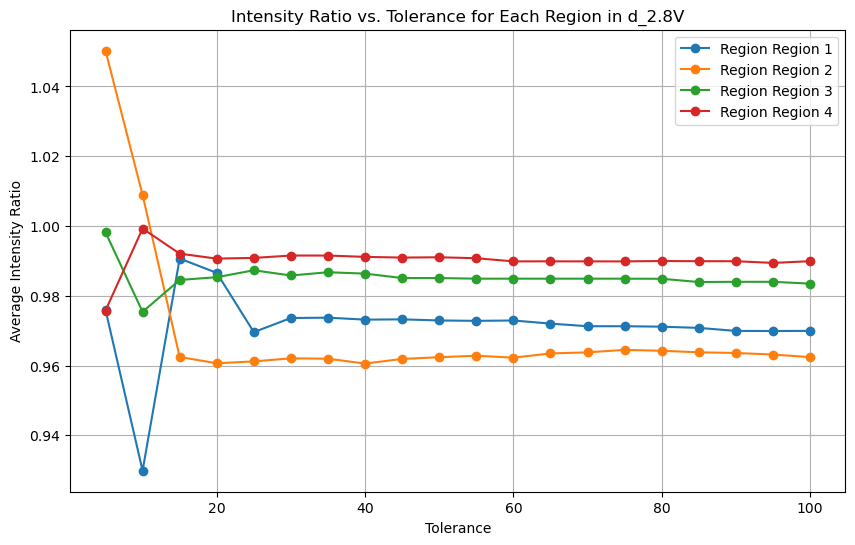

In [ ]:
region_intensity_ratios = {}

for region in regions1.keys():
    if region in regions2:
        df1 = regions1[region]
        df2 = regions2[region]
        
        intensity_ratios = []
        
        for tolerance in tolerances:
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                intensity_ratios.append(avg_intensity_ratio)
            else:
                intensity_ratios.append(np.nan)  # Use NaN if no matches to avoid skewing results
        
        region_intensity_ratios[region] = intensity_ratios


plt.figure(figsize=(10, 6))

for region, intensity_ratios in region_intensity_ratios.items():
    plt.plot(tolerances, intensity_ratios, marker='o', linestyle='-', label=f"Region {region}")

plt.xlabel("Tolerance")
plt.ylabel("Average Intensity Ratio")
plt.title(f"Intensity Ratio vs. Tolerance for Each Region in {sheet1}")
plt.legend()
plt.grid()
plt.show()

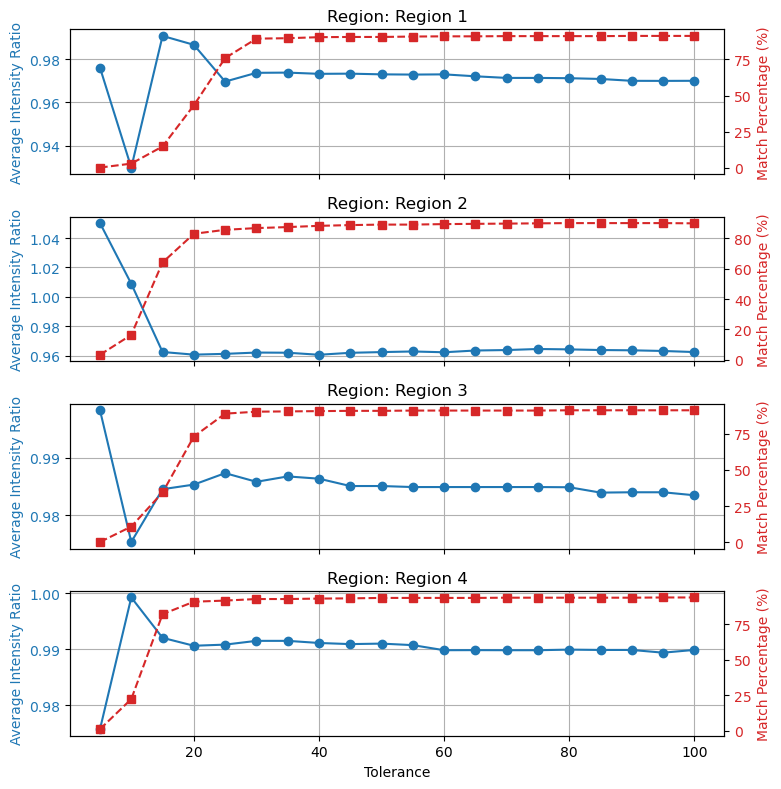

In [ ]:
region_data = {}

for region in regions1.keys():
    if region in regions2:
        df1 = regions1[region]
        df2 = regions2[region]
        
        intensity_ratios = []
        match_percentages = []
        
        for tolerance in tolerances:
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                match_percentage = (num_matched / min(len(df1), len(df2))) * 100
            else:
                avg_intensity_ratio = np.nan
                match_percentage = 0  # No matches found
            
            intensity_ratios.append(avg_intensity_ratio)
            match_percentages.append(match_percentage)
        
        region_data[region] = {
            "intensity_ratios": intensity_ratios,
            "match_percentages": match_percentages
        }

# Create stacked vertical plots
num_regions = len(region_data)
fig, axes = plt.subplots(num_regions, 1, figsize=(8, 2 * num_regions), sharex=True)

# If only one region, convert axes to list for iteration
if num_regions == 1:
    axes = [axes]

for ax, (region, data) in zip(axes, region_data.items()):
    ax.set_ylabel("Average Intensity Ratio", color="tab:blue")
    ax.plot(tolerances, data["intensity_ratios"], marker='o', linestyle='-', color="tab:blue", label=f"Intensity Ratio")
    ax.tick_params(axis='y', labelcolor="tab:blue")
    
    # Second y-axis for match percentage
    ax2 = ax.twinx()
    ax2.set_ylabel("Match Percentage (%)", color="tab:red")
    ax2.plot(tolerances, data["match_percentages"], marker='s', linestyle='--', color="tab:red", label=f"Match %")
    ax2.tick_params(axis='y', labelcolor="tab:red")
    
    ax.set_title(f"Region: {region}")
    ax.grid()

# Set common x-axis label
axes[-1].set_xlabel("Tolerance")

plt.tight_layout()
plt.show()

In [ ]:
sheet2 = '....'
regions3 = extract_regions(file1, sheet2)
regions4 = extract_regions(file2, sheet2)

for region in regions3.keys():
    if region in regions4:
        df1 = regions3[region]
        df2 = regions4[region]
        print(f"Region: {region} \n Entries in df1: {len(df1)}, Entries in df2: {len(df2)}")
        matched_df, num_matched = match_particles(regions3[region], regions4[region], tolerance=100.0)
        print(f"Matched particles: {num_matched}, Match % = {num_matched/min(len(df1), len(df2))*100:.2f}")
        print(f"Intensity ratio average = {np.mean(matched_df['intensity_ratio']):.3f}")
        print(matched_df.head())
        print("-" * 50)

Region: Region 1 
 Entries in df1: 911, Entries in df2: 915
Matched particles: 825, Match % = 90.56
Intensity ratio average = 1.018
    Centroid_X   Centroid_Y  intensity_ratio
0  2199.114598  1671.093487         0.987911
1   740.243243    32.414283         0.974130
2   896.695224    55.696226         1.189130
3  1096.138021    40.260218         1.005311
4  1427.327394   168.489801         1.079283
--------------------------------------------------
Region: Region 2 
 Entries in df1: 819, Entries in df2: 790
Matched particles: 732, Match % = 92.66
Intensity ratio average = 1.001
    Centroid_X   Centroid_Y  intensity_ratio
0  2224.452160  1609.747851         0.979121
1   373.763272    30.445887         1.000016
2   735.900987    22.272779         0.998336
3  1352.303638    21.581435         0.999635
4  1517.188438    21.537538         1.082637
--------------------------------------------------
Region: Region 3 
 Entries in df1: 733, Entries in df2: 698
Matched particles: 640, Match % = 

In [ ]:
matched_regions = {}

for region in regions3.keys():
    if region in regions4:
        df1 = regions3[region]
        df2 = regions4[region]
        matched_df, num_matched = match_particles(df1, df2, tolerance=100.0)
        matched_regions[region] = matched_df

output_file = f"matched_particles_{sheet2}.xlsx"

with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    all_regions = []
    
    for region, matched_df in matched_regions.items():
        matched_df = matched_df[['Centroid_X', 'Centroid_Y', 'intensity_ratio']]
        
        all_regions.append(matched_df)
    
    final_df = pd.concat(all_regions, axis=1)
    
    # Write to an Excel file (single sheet)
    final_df.to_excel(writer, sheet_name='Matched Data', index=False)

print(f"Exported matched data to {output_file}")

Exported matched data to matched_particles_d_3.71V_1.xlsx


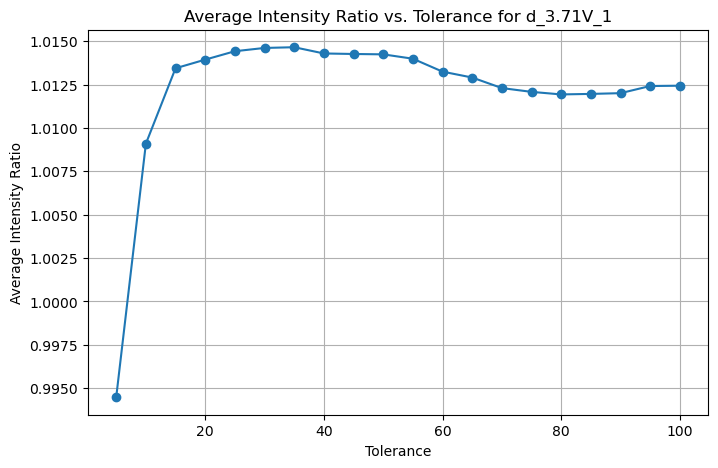

In [10]:
tolerances = np.linspace(5,100,20)

# Store results
tolerance_values = []
average_intensity_ratios = []

for tolerance in tolerances:
    total_intensity_ratios = []
    
    for region in regions3.keys():
        if region in regions4:
            df1 = regions3[region]
            df2 = regions4[region]
            
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                total_intensity_ratios.append(avg_intensity_ratio)

    if total_intensity_ratios:
        tolerance_values.append(tolerance)
        average_intensity_ratios.append(np.mean(total_intensity_ratios))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(tolerance_values, average_intensity_ratios, marker='o', linestyle='-')
plt.xlabel("Tolerance")
plt.ylabel("Average Intensity Ratio")
plt.title(f"Average Intensity Ratio vs. Tolerance for {sheet2}")
plt.grid()
plt.show()

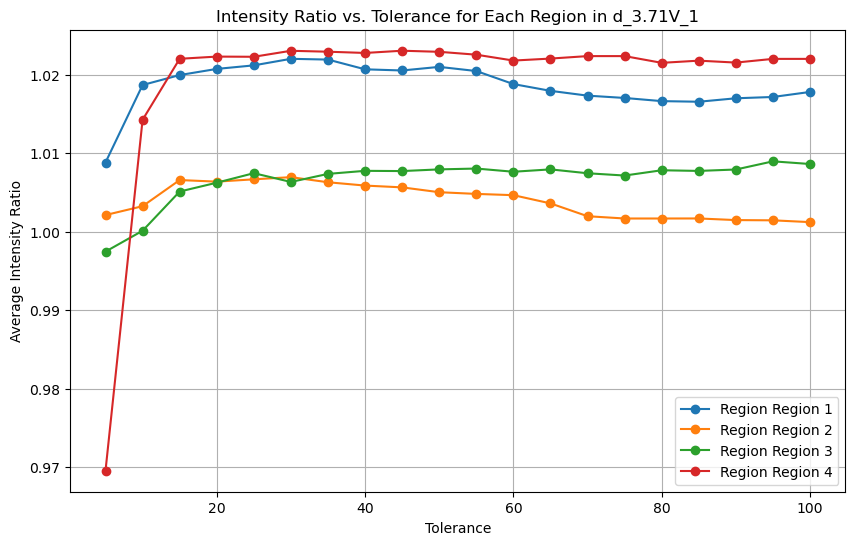

In [ ]:
region_intensity_ratios = {}

for region in regions3.keys():
    if region in regions4:
        df1 = regions3[region]
        df2 = regions4[region]
        
        intensity_ratios = []
        
        for tolerance in tolerances:
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                intensity_ratios.append(avg_intensity_ratio)
            else:
                intensity_ratios.append(np.nan)  # Use NaN if no matches to avoid skewing results
        
        region_intensity_ratios[region] = intensity_ratios

plt.figure(figsize=(10, 6))

for region, intensity_ratios in region_intensity_ratios.items():
    plt.plot(tolerances, intensity_ratios, marker='o', linestyle='-', label=f"Region {region}")

plt.xlabel("Tolerance")
plt.ylabel("Average Intensity Ratio")
plt.title(f"Intensity Ratio vs. Tolerance for Each Region in {sheet2}")
plt.legend()
plt.grid()
plt.show()

In [12]:
# # Dictionary to store intensity ratio and match % per region
# region_data = {}

# for region in regions1.keys():
#     if region in regions2:
#         df1 = regions1[region]
#         df2 = regions2[region]
        
#         intensity_ratios = []
#         match_percentages = []
        
#         for tolerance in tolerances:
#             matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
#             if num_matched > 0:
#                 avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
#                 match_percentage = (num_matched / min(len(df1), len(df2))) * 100
#             else:
#                 avg_intensity_ratio = np.nan
#                 match_percentage = 0  # No matches found
            
#             intensity_ratios.append(avg_intensity_ratio)
#             match_percentages.append(match_percentage)
        
#         region_data[region] = {
#             "intensity_ratios": intensity_ratios,
#             "match_percentages": match_percentages
#         }

# # Plot intensity ratio & match % for each region
# plt.figure(figsize=(12, 6))

# for region, data in region_data.items():
#     fig, ax1 = plt.subplots(figsize=(10, 5))
    
#     ax1.set_xlabel("Tolerance")
#     ax1.set_ylabel("Average Intensity Ratio", color="tab:blue")
#     ax1.plot(tolerances, data["intensity_ratios"], marker='o', linestyle='-', color="tab:blue", label=f"Intensity Ratio ({region})")
#     ax1.tick_params(axis='y', labelcolor="tab:blue")
    
#     # Create second y-axis for match percentage
#     ax2 = ax1.twinx()
#     ax2.set_ylabel("Match Percentage (%)", color="tab:red")
#     ax2.plot(tolerances, data["match_percentages"], marker='s', linestyle='--', color="tab:red", label=f"Match % ({region})")
#     ax2.tick_params(axis='y', labelcolor="tab:red")
    
#     plt.title(f"Region: {region} - Intensity Ratio & Match % vs. Tolerance")
#     fig.tight_layout()
#     plt.grid()
#     plt.show()

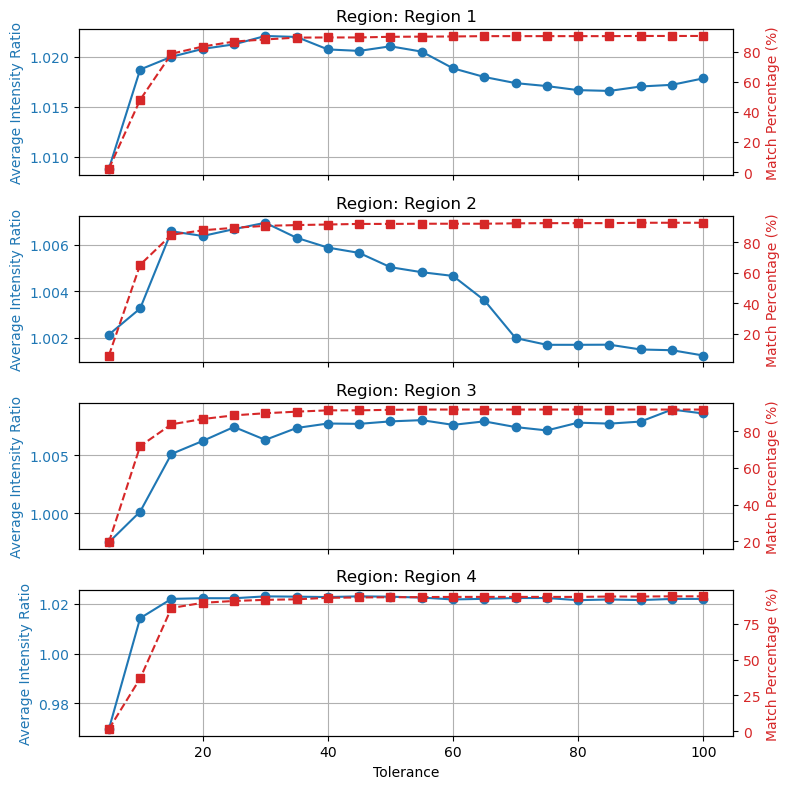

In [12]:
region_data = {}

for region in regions3.keys():
    if region in regions4:
        df1 = regions3[region]
        df2 = regions4[region]
        
        intensity_ratios = []
        match_percentages = []
        
        for tolerance in tolerances:
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                match_percentage = (num_matched / min(len(df1), len(df2))) * 100
            else:
                avg_intensity_ratio = np.nan
                match_percentage = 0  # No matches found
            
            intensity_ratios.append(avg_intensity_ratio)
            match_percentages.append(match_percentage)
        
        region_data[region] = {
            "intensity_ratios": intensity_ratios,
            "match_percentages": match_percentages
        }

# Create stacked vertical plots
num_regions = len(region_data)
fig, axes = plt.subplots(num_regions, 1, figsize=(8, 2 * num_regions), sharex=True)

# If only one region, convert axes to list for iteration
if num_regions == 1:
    axes = [axes]

for ax, (region, data) in zip(axes, region_data.items()):
    ax.set_ylabel("Average Intensity Ratio", color="tab:blue")
    ax.plot(tolerances, data["intensity_ratios"], marker='o', linestyle='-', color="tab:blue", label=f"Intensity Ratio")
    ax.tick_params(axis='y', labelcolor="tab:blue")
    
    # Create second y-axis for match percentage
    ax2 = ax.twinx()
    ax2.set_ylabel("Match Percentage (%)", color="tab:red")
    ax2.plot(tolerances, data["match_percentages"], marker='s', linestyle='--', color="tab:red", label=f"Match %")
    ax2.tick_params(axis='y', labelcolor="tab:red")
    
    ax.set_title(f"Region: {region}")
    ax.grid()

# Set common x-axis label
axes[-1].set_xlabel("Tolerance")

plt.tight_layout()
plt.show()

In [ ]:
sheet3 = '....'
regions5 = extract_regions(file1, sheet3)
regions6 = extract_regions(file2, sheet3)

for region in regions5.keys():
    if region in regions6:
        df1 = regions5[region]
        df2 = regions6[region]
        print(f"Region: {region} \n Entries in df1: {len(df1)}, Entries in df2: {len(df2)}")
        matched_df, num_matched = match_particles(regions5[region], regions6[region], tolerance=100.0)
        print(f"Matched particles: {num_matched}, Match % = {num_matched/min(len(df1), len(df2))*100:.2f}")
        print(f"Intensity ratio average = {np.mean(matched_df['intensity_ratio']):.3f}")
        print(matched_df.head())
        print("-" * 50)

Region: Region 1 
 Entries in df1: 977, Entries in df2: 981
Matched particles: 909, Match % = 93.04
Intensity ratio average = 1.093
    Centroid_X   Centroid_Y  intensity_ratio
0  2239.104509  1663.960951         1.026251
1   149.079200    11.625600         1.320623
2   260.369048    50.363287         1.057043
3   498.386436    14.342290         1.164911
4   619.495795    20.204022         1.137243
--------------------------------------------------
Region: Region 2 
 Entries in df1: 845, Entries in df2: 791
Matched particles: 753, Match % = 95.20
Intensity ratio average = 1.062
    Centroid_X   Centroid_Y  intensity_ratio
0  2150.064466  1675.095008         1.033213
1    26.012533    49.388530         1.136304
2   502.494415    38.597124         1.164127
3   870.378562    23.726594         1.178050
4  2506.906229    29.829927         1.095909
--------------------------------------------------
Region: Region 3 
 Entries in df1: 785, Entries in df2: 808
Matched particles: 736, Match % = 

In [ ]:
matched_regions = {}

for region in regions5.keys():
    if region in regions6:
        df1 = regions5[region]
        df2 = regions6[region]
        matched_df, num_matched = match_particles(df1, df2, tolerance=100.0)
        matched_regions[region] = matched_df

output_file = f"matched_particles_{sheet3}.xlsx"

with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    all_regions = []
    
    for region, matched_df in matched_regions.items():
        matched_df = matched_df[['Centroid_X', 'Centroid_Y', 'intensity_ratio']]
        
        all_regions.append(matched_df)
    
    final_df = pd.concat(all_regions, axis=1)
    
    # Write to an Excel file (single sheet)
    final_df.to_excel(writer, sheet_name='Matched Data', index=False)

print(f"Exported matched data to {output_file}")

Exported matched data to matched_particles_d_3.71V_2.xlsx


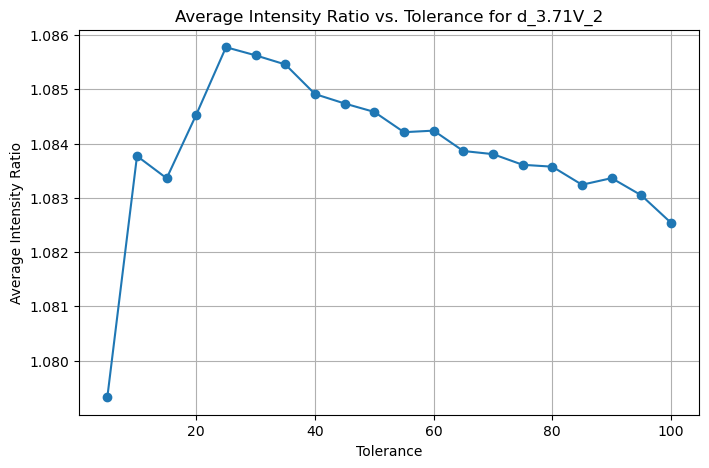

In [15]:
tolerances = np.linspace(5,100,20)

# Store results
tolerance_values = []
average_intensity_ratios = []

for tolerance in tolerances:
    total_intensity_ratios = []
    
    for region in regions5.keys():
        if region in regions6:
            df1 = regions5[region]
            df2 = regions6[region]
            
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                total_intensity_ratios.append(avg_intensity_ratio)

    if total_intensity_ratios:
        tolerance_values.append(tolerance)
        average_intensity_ratios.append(np.mean(total_intensity_ratios))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(tolerance_values, average_intensity_ratios, marker='o', linestyle='-')
plt.xlabel("Tolerance")
plt.ylabel("Average Intensity Ratio")
plt.title(f"Average Intensity Ratio vs. Tolerance for {sheet3}")
plt.grid()
plt.show()

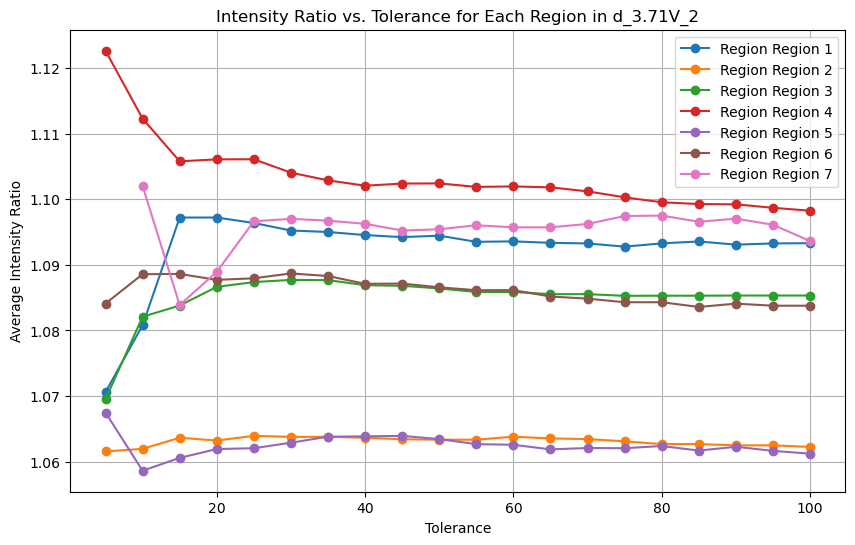

In [ ]:
region_intensity_ratios = {}

for region in regions5.keys():
    if region in regions6:
        df1 = regions5[region]
        df2 = regions6[region]
        
        intensity_ratios = []
        
        for tolerance in tolerances:
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                intensity_ratios.append(avg_intensity_ratio)
            else:
                intensity_ratios.append(np.nan)  # Use NaN if no matches to avoid skewing results
        
        region_intensity_ratios[region] = intensity_ratios

plt.figure(figsize=(10, 6))

for region, intensity_ratios in region_intensity_ratios.items():
    plt.plot(tolerances, intensity_ratios, marker='o', linestyle='-', label=f"Region {region}")

plt.xlabel("Tolerance")
plt.ylabel("Average Intensity Ratio")
plt.title(f"Intensity Ratio vs. Tolerance for Each Region in {sheet3}")
plt.legend()
plt.grid()
plt.show()

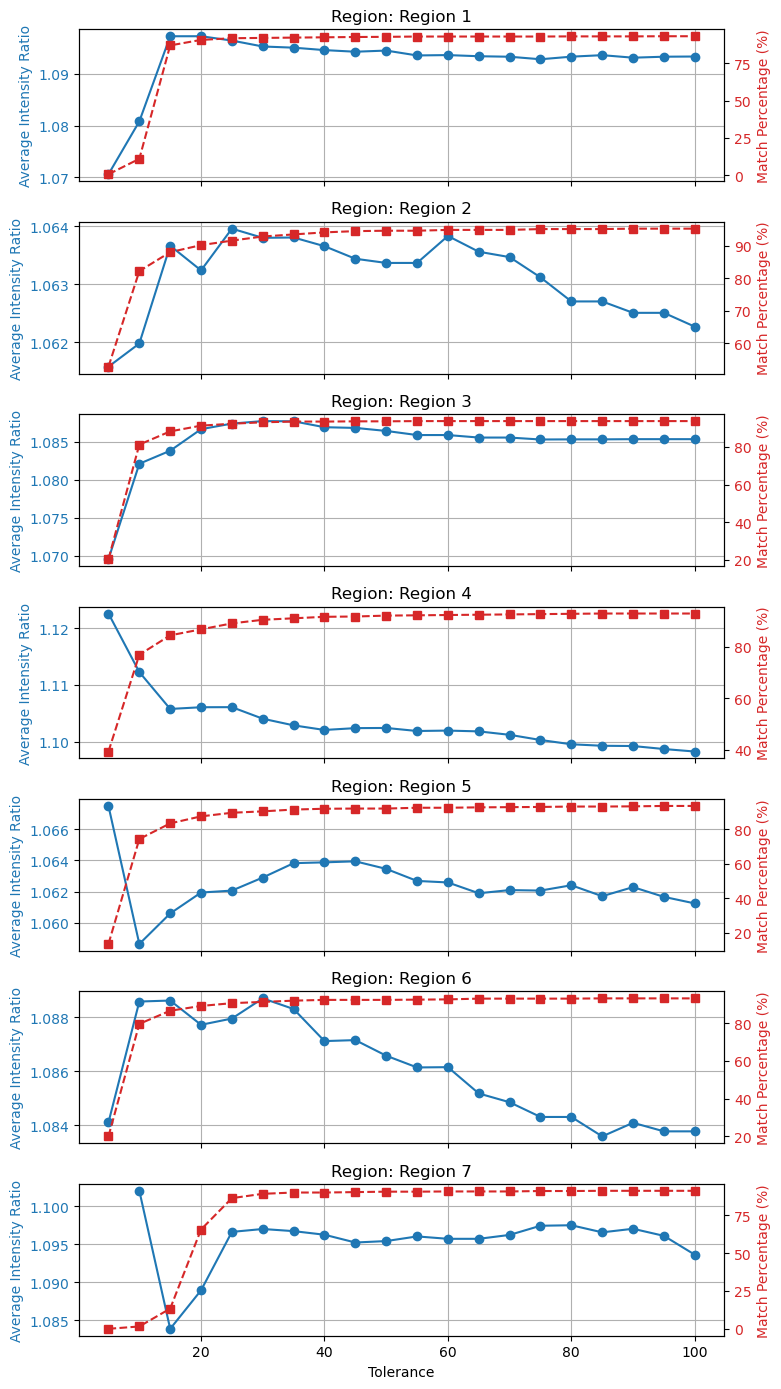

In [17]:
region_data = {}

for region in regions5.keys():
    if region in regions6:
        df1 = regions5[region]
        df2 = regions6[region]
        
        intensity_ratios = []
        match_percentages = []
        
        for tolerance in tolerances:
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                match_percentage = (num_matched / min(len(df1), len(df2))) * 100
            else:
                avg_intensity_ratio = np.nan
                match_percentage = 0  # No matches found
            
            intensity_ratios.append(avg_intensity_ratio)
            match_percentages.append(match_percentage)
        
        region_data[region] = {
            "intensity_ratios": intensity_ratios,
            "match_percentages": match_percentages
        }

# Create stacked vertical plots
num_regions = len(region_data)
fig, axes = plt.subplots(num_regions, 1, figsize=(8, 2 * num_regions), sharex=True)

# If only one region, convert axes to list for iteration
if num_regions == 1:
    axes = [axes]

for ax, (region, data) in zip(axes, region_data.items()):
    ax.set_ylabel("Average Intensity Ratio", color="tab:blue")
    ax.plot(tolerances, data["intensity_ratios"], marker='o', linestyle='-', color="tab:blue", label=f"Intensity Ratio")
    ax.tick_params(axis='y', labelcolor="tab:blue")
    
    # Create second y-axis for match percentage
    ax2 = ax.twinx()
    ax2.set_ylabel("Match Percentage (%)", color="tab:red")
    ax2.plot(tolerances, data["match_percentages"], marker='s', linestyle='--', color="tab:red", label=f"Match %")
    ax2.tick_params(axis='y', labelcolor="tab:red")
    
    ax.set_title(f"Region: {region}")
    ax.grid()

# Set common x-axis label
axes[-1].set_xlabel("Tolerance")

plt.tight_layout()
plt.show()

In [ ]:
sheet4 = '....'
regions7 = extract_regions(file1, sheet4)
regions8 = extract_regions(file2, sheet4)

for region in regions7.keys():
    if region in regions8:
        df1 = regions7[region]
        df2 = regions8[region]
        print(f"Region: {region} \n Entries in df1: {len(df1)}, Entries in df2: {len(df2)}")
        matched_df, num_matched = match_particles(regions7[region], regions8[region], tolerance=100.0)
        print(f"Matched particles: {num_matched}, Match % = {num_matched/min(len(df1), len(df2))*100:.2f}")
        print(f"Intensity ratio average = {np.mean(matched_df['intensity_ratio']):.3f}")
        print(matched_df.head())
        print("-" * 50)

Region: Region 1 
 Entries in df1: 779, Entries in df2: 924
Matched particles: 655, Match % = 84.08
Intensity ratio average = 1.168
    Centroid_X   Centroid_Y  intensity_ratio
0  2222.258284  1656.830720         1.133950
1   940.107964    41.804848         0.870543
2  1493.841200    17.107190         0.969463
3  1764.543199    22.648162         1.084429
4  2250.418296    10.384078         1.268353
--------------------------------------------------
Region: Region 2 
 Entries in df1: 514, Entries in df2: 891
Matched particles: 449, Match % = 87.35
Intensity ratio average = 1.212
    Centroid_X   Centroid_Y  intensity_ratio
0  2222.221895  1660.706957         1.230784
1   175.562738    16.907659         1.020525
2  1344.279183    40.585211         1.422517
3  1573.007205    25.036784         1.269293
4  1732.925616    26.785218         1.561974
--------------------------------------------------
Region: Region 3 
 Entries in df1: 714, Entries in df2: 754
Matched particles: 612, Match % = 

In [ ]:
matched_regions = {}

for region in regions7.keys():
    if region in regions8:
        df1 = regions7[region]
        df2 = regions8[region]
        matched_df, num_matched = match_particles(df1, df2, tolerance=100.0)
        matched_regions[region] = matched_df

output_file = f"matched_particles_{sheet4}.xlsx"

with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    all_regions = []
    
    for region, matched_df in matched_regions.items():
        matched_df = matched_df[['Centroid_X', 'Centroid_Y', 'intensity_ratio']]
        
        all_regions.append(matched_df)

    final_df = pd.concat(all_regions, axis=1)
    
    # Write to an Excel file (single sheet)
    final_df.to_excel(writer, sheet_name='Matched Data', index=False)

print(f"Exported matched data to {output_file}")

Exported matched data to matched_particles_d_4.1V.xlsx


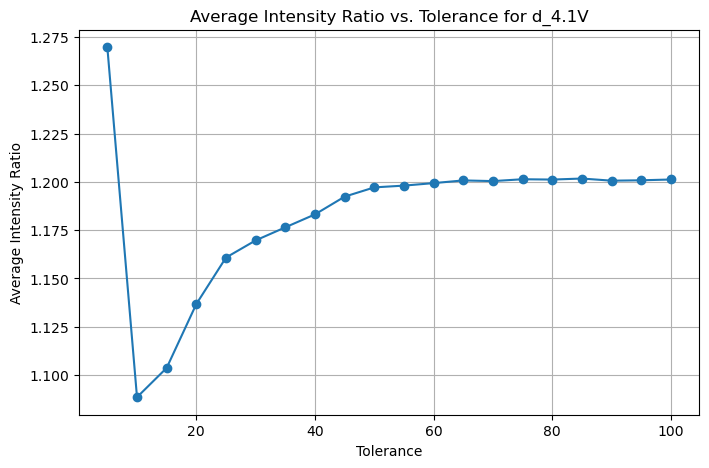

In [20]:
tolerances = np.linspace(5,100,20)

# Store results
tolerance_values = []
average_intensity_ratios = []

for tolerance in tolerances:
    total_intensity_ratios = []
    
    for region in regions7.keys():
        if region in regions8:
            df1 = regions7[region]
            df2 = regions8[region]
            
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                total_intensity_ratios.append(avg_intensity_ratio)

    if total_intensity_ratios:
        tolerance_values.append(tolerance)
        average_intensity_ratios.append(np.mean(total_intensity_ratios))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(tolerance_values, average_intensity_ratios, marker='o', linestyle='-')
plt.xlabel("Tolerance")
plt.ylabel("Average Intensity Ratio")
plt.title(f"Average Intensity Ratio vs. Tolerance for {sheet4}")
plt.grid()
plt.show()

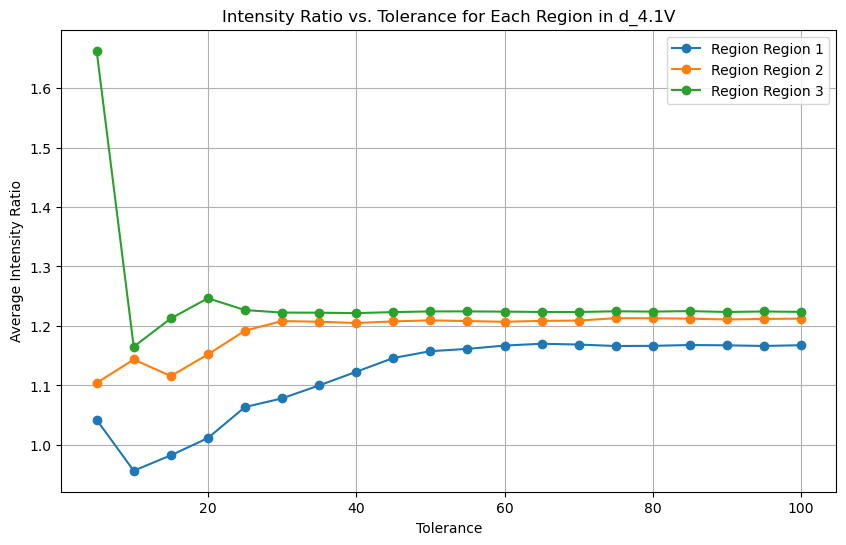

In [ ]:
region_intensity_ratios = {}

for region in regions7.keys():
    if region in regions8:
        df1 = regions7[region]
        df2 = regions8[region]
        
        intensity_ratios = []
        
        for tolerance in tolerances:
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                intensity_ratios.append(avg_intensity_ratio)
            else:
                intensity_ratios.append(np.nan)  # Use NaN if no matches to avoid skewing results
        
        region_intensity_ratios[region] = intensity_ratios

plt.figure(figsize=(10, 6))

for region, intensity_ratios in region_intensity_ratios.items():
    plt.plot(tolerances, intensity_ratios, marker='o', linestyle='-', label=f"Region {region}")

plt.xlabel("Tolerance")
plt.ylabel("Average Intensity Ratio")
plt.title(f"Intensity Ratio vs. Tolerance for Each Region in {sheet4}")
plt.legend()
plt.grid()
plt.show()

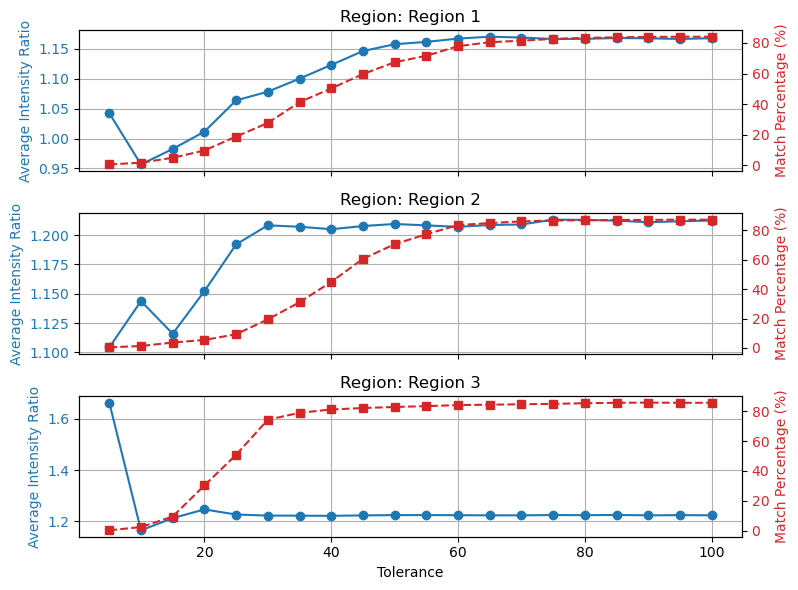

In [22]:
region_data = {}

for region in regions7.keys():
    if region in regions8:
        df1 = regions7[region]
        df2 = regions8[region]
        
        intensity_ratios = []
        match_percentages = []
        
        for tolerance in tolerances:
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                match_percentage = (num_matched / min(len(df1), len(df2))) * 100
            else:
                avg_intensity_ratio = np.nan
                match_percentage = 0  # No matches found
            
            intensity_ratios.append(avg_intensity_ratio)
            match_percentages.append(match_percentage)
        
        region_data[region] = {
            "intensity_ratios": intensity_ratios,
            "match_percentages": match_percentages
        }

# Create stacked vertical plots
num_regions = len(region_data)
fig, axes = plt.subplots(num_regions, 1, figsize=(8, 2 * num_regions), sharex=True)

# If only one region, convert axes to list for iteration
if num_regions == 1:
    axes = [axes]

for ax, (region, data) in zip(axes, region_data.items()):
    ax.set_ylabel("Average Intensity Ratio", color="tab:blue")
    ax.plot(tolerances, data["intensity_ratios"], marker='o', linestyle='-', color="tab:blue", label=f"Intensity Ratio")
    ax.tick_params(axis='y', labelcolor="tab:blue")
    
    # Create second y-axis for match percentage
    ax2 = ax.twinx()
    ax2.set_ylabel("Match Percentage (%)", color="tab:red")
    ax2.plot(tolerances, data["match_percentages"], marker='s', linestyle='--', color="tab:red", label=f"Match %")
    ax2.tick_params(axis='y', labelcolor="tab:red")
    
    ax.set_title(f"Region: {region}")
    ax.grid()

# Set common x-axis label
axes[-1].set_xlabel("Tolerance")

plt.tight_layout()
plt.show()

In [ ]:
sheet5 = '....'
regions9 = extract_regions(file1, sheet5)
regions10 = extract_regions(file2, sheet5)

for region in regions9.keys():
    if region in regions10:
        df1 = regions9[region]
        df2 = regions10[region]
        print(f"Region: {region} \n Entries in df1: {len(df1)}, Entries in df2: {len(df2)}")
        matched_df, num_matched = match_particles(regions9[region], regions10[region], tolerance=100.0)
        print(f"Matched particles: {num_matched}, Match % = {num_matched/min(len(df1), len(df2))*100:.2f}")
        print(f"Intensity ratio average = {np.mean(matched_df['intensity_ratio']):.3f}")
        print(matched_df.head())
        print("-" * 50)

Region: Region 1 
 Entries in df1: 780, Entries in df2: 740
Matched particles: 701, Match % = 94.73
Intensity ratio average = 1.253
    Centroid_X   Centroid_Y  intensity_ratio
0  2274.782681  1654.408544         1.134484
1   255.351933    23.297112         1.180058
2  1427.176063    20.622458         1.244503
3  1728.259483     9.821552         1.184346
4  1901.765432    25.555247         1.368702
--------------------------------------------------
Region: Region 2 
 Entries in df1: 750, Entries in df2: 728
Matched particles: 674, Match % = 92.58
Intensity ratio average = 1.272
    Centroid_X   Centroid_Y  intensity_ratio
0  2202.166850  1696.946598         1.151691
1   231.242675    35.379849         1.255295
2   483.449659    76.355237         1.310170
3   616.458594    25.215901         1.481345
4   968.424444    25.641919         1.411077
--------------------------------------------------
Region: Region 3 
 Entries in df1: 791, Entries in df2: 836
Matched particles: 739, Match % = 

In [ ]:
matched_regions = {}

for region in regions9.keys():
    if region in regions10:
        df1 = regions9[region]
        df2 = regions10[region]
        matched_df, num_matched = match_particles(df1, df2, tolerance=100.0)
        matched_regions[region] = matched_df

output_file = f"matched_particles_{sheet5}.xlsx"

with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    all_regions = []
    
    for region, matched_df in matched_regions.items():
        matched_df = matched_df[['Centroid_X', 'Centroid_Y', 'intensity_ratio']]
        
        all_regions.append(matched_df)

    final_df = pd.concat(all_regions, axis=1)
    
    # Write to an Excel file (single sheet)
    final_df.to_excel(writer, sheet_name='Matched Data', index=False)

print(f"Exported matched data to {output_file}")

Exported matched data to matched_particles_c_4.17V_1.xlsx


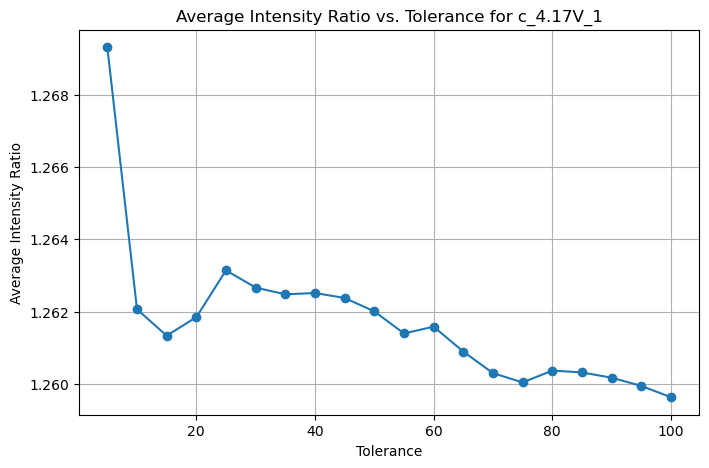

In [25]:
tolerances = np.linspace(5,100,20)

# Store results
tolerance_values = []
average_intensity_ratios = []

for tolerance in tolerances:
    total_intensity_ratios = []
    
    for region in regions9.keys():
        if region in regions10:
            df1 = regions9[region]
            df2 = regions10[region]
            
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                total_intensity_ratios.append(avg_intensity_ratio)

    if total_intensity_ratios:
        tolerance_values.append(tolerance)
        average_intensity_ratios.append(np.mean(total_intensity_ratios))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(tolerance_values, average_intensity_ratios, marker='o', linestyle='-')
plt.xlabel("Tolerance")
plt.ylabel("Average Intensity Ratio")
plt.title(f"Average Intensity Ratio vs. Tolerance for {sheet5}")
plt.grid()
plt.show()

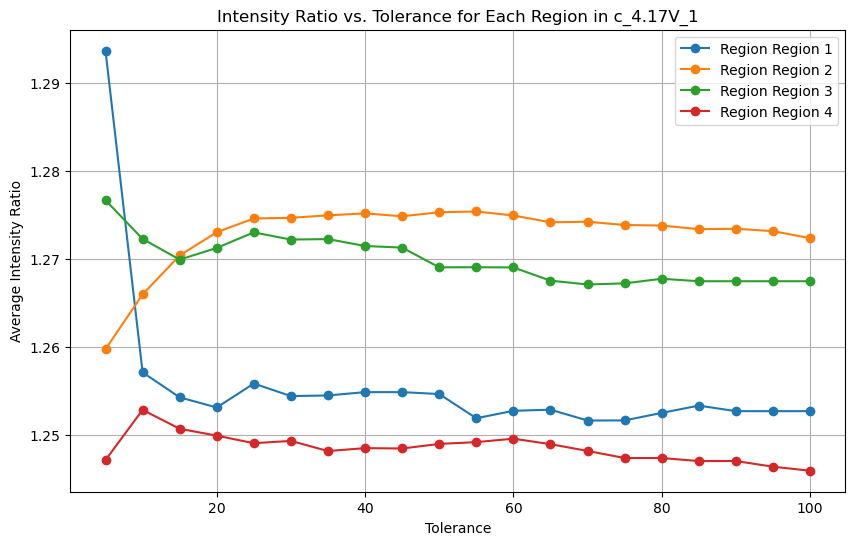

In [ ]:
region_intensity_ratios = {}

for region in regions9.keys():
    if region in regions10:
        df1 = regions9[region]
        df2 = regions10[region]
        
        intensity_ratios = []
        
        for tolerance in tolerances:
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                intensity_ratios.append(avg_intensity_ratio)
            else:
                intensity_ratios.append(np.nan)  # Use NaN if no matches to avoid skewing results
        
        region_intensity_ratios[region] = intensity_ratios

plt.figure(figsize=(10, 6))

for region, intensity_ratios in region_intensity_ratios.items():
    plt.plot(tolerances, intensity_ratios, marker='o', linestyle='-', label=f"Region {region}")

plt.xlabel("Tolerance")
plt.ylabel("Average Intensity Ratio")
plt.title(f"Intensity Ratio vs. Tolerance for Each Region in {sheet5}")
plt.legend()
plt.grid()
plt.show()

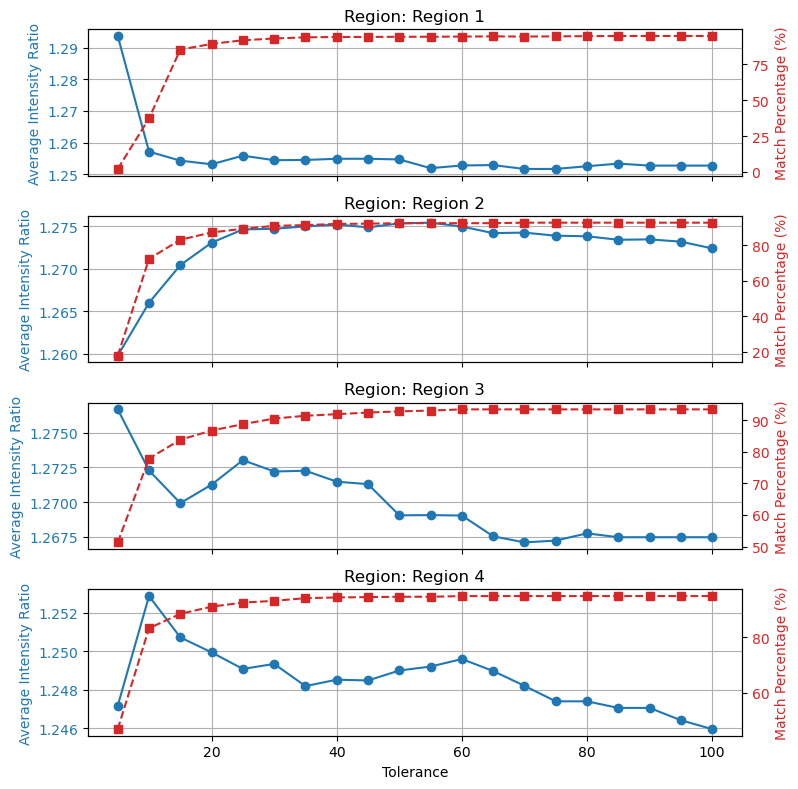

In [27]:
region_data = {}

for region in regions9.keys():
    if region in regions10:
        df1 = regions9[region]
        df2 = regions10[region]
        
        intensity_ratios = []
        match_percentages = []
        
        for tolerance in tolerances:
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                match_percentage = (num_matched / min(len(df1), len(df2))) * 100
            else:
                avg_intensity_ratio = np.nan
                match_percentage = 0  # No matches found
            
            intensity_ratios.append(avg_intensity_ratio)
            match_percentages.append(match_percentage)
        
        region_data[region] = {
            "intensity_ratios": intensity_ratios,
            "match_percentages": match_percentages
        }

# Create stacked vertical plots
num_regions = len(region_data)
fig, axes = plt.subplots(num_regions, 1, figsize=(8, 2 * num_regions), sharex=True)

# If only one region, convert axes to list for iteration
if num_regions == 1:
    axes = [axes]

for ax, (region, data) in zip(axes, region_data.items()):
    ax.set_ylabel("Average Intensity Ratio", color="tab:blue")
    ax.plot(tolerances, data["intensity_ratios"], marker='o', linestyle='-', color="tab:blue", label=f"Intensity Ratio")
    ax.tick_params(axis='y', labelcolor="tab:blue")
    
    # Create second y-axis for match percentage
    ax2 = ax.twinx()
    ax2.set_ylabel("Match Percentage (%)", color="tab:red")
    ax2.plot(tolerances, data["match_percentages"], marker='s', linestyle='--', color="tab:red", label=f"Match %")
    ax2.tick_params(axis='y', labelcolor="tab:red")
    
    ax.set_title(f"Region: {region}")
    ax.grid()

# Set common x-axis label
axes[-1].set_xlabel("Tolerance")

plt.tight_layout()
plt.show()

In [ ]:
sheet6 = '....'
regions11 = extract_regions(file1, sheet6)
regions12 = extract_regions(file2, sheet6)

for region in regions11.keys():
    if region in regions12:
        df1 = regions11[region]
        df2 = regions12[region]
        print(f"Region: {region} \n Entries in df1: {len(df1)}, Entries in df2: {len(df2)}")
        matched_df, num_matched = match_particles(regions11[region], regions12[region], tolerance=100.0)
        print(f"Matched particles: {num_matched}, Match % = {num_matched/min(len(df1), len(df2))*100:.2f}")
        print(f"Intensity ratio average = {np.mean(matched_df['intensity_ratio']):.3f}")
        print(matched_df.head())
        print("-" * 50)

Region: Region 1 
 Entries in df1: 907, Entries in df2: 811
Matched particles: 747, Match % = 92.11
Intensity ratio average = 1.214
    Centroid_X   Centroid_Y  intensity_ratio
0  2095.128711  1669.485270         1.128111
1   437.523786    17.854281         0.948259
2   533.761058    34.238942         1.306248
3   686.619289    16.616389         1.248569
4  1719.715040    21.030310         1.201634
--------------------------------------------------
Region: Region 2 
 Entries in df1: 907, Entries in df2: 735
Matched particles: 678, Match % = 92.24
Intensity ratio average = 1.317
    Centroid_X   Centroid_Y  intensity_ratio
0  2180.728191  1668.281315         0.355223
1    55.625875    25.613538         1.133277
2   698.923128    32.163436         1.327593
3  1039.863669    29.090827         1.335234
4  1757.738921    46.977427         1.238334
--------------------------------------------------
Region: Region 3 
 Entries in df1: 806, Entries in df2: 811
Matched particles: 747, Match % = 

In [ ]:
matched_regions = {}

for region in regions11.keys():
    if region in regions12:
        df1 = regions11[region]
        df2 = regions12[region]
        matched_df, num_matched = match_particles(df1, df2, tolerance=100.0)
        matched_regions[region] = matched_df

output_file = f"matched_particles_{sheet6}.xlsx"

with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    all_regions = []
    
    for region, matched_df in matched_regions.items():
        matched_df = matched_df[['Centroid_X', 'Centroid_Y', 'intensity_ratio']]
        
        all_regions.append(matched_df)

    final_df = pd.concat(all_regions, axis=1)
    
    # Write to an Excel file (single sheet)
    final_df.to_excel(writer, sheet_name='Matched Data', index=False)

print(f"Exported matched data to {output_file}")

Exported matched data to matched_particles_c_4.17V_2.xlsx


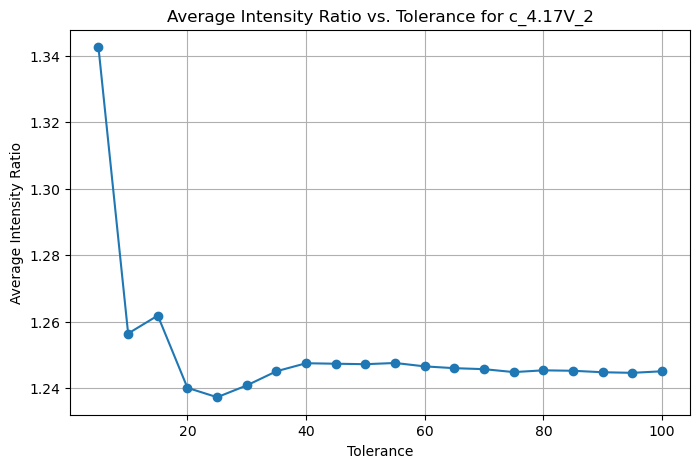

In [30]:
tolerances = np.linspace(5,100,20)

# Store results
tolerance_values = []
average_intensity_ratios = []

for tolerance in tolerances:
    total_intensity_ratios = []
    
    for region in regions11.keys():
        if region in regions12:
            df1 = regions11[region]
            df2 = regions12[region]
            
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                total_intensity_ratios.append(avg_intensity_ratio)

    if total_intensity_ratios:
        tolerance_values.append(tolerance)
        average_intensity_ratios.append(np.mean(total_intensity_ratios))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(tolerance_values, average_intensity_ratios, marker='o', linestyle='-')
plt.xlabel("Tolerance")
plt.ylabel("Average Intensity Ratio")
plt.title(f"Average Intensity Ratio vs. Tolerance for {sheet6}")
plt.grid()
plt.show()

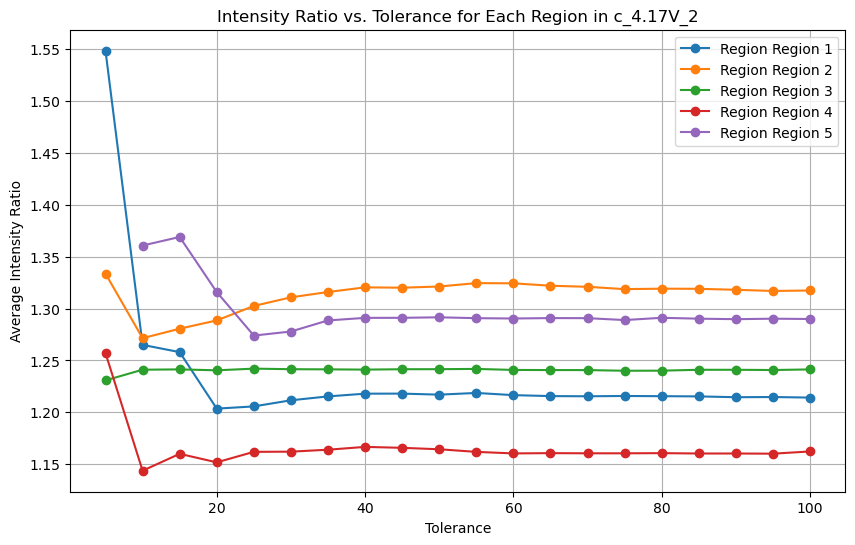

In [ ]:
region_intensity_ratios = {}

for region in regions11.keys():
    if region in regions12:
        df1 = regions11[region]
        df2 = regions12[region]
        
        intensity_ratios = []
        
        for tolerance in tolerances:
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                intensity_ratios.append(avg_intensity_ratio)
            else:
                intensity_ratios.append(np.nan)  # Use NaN if no matches to avoid skewing results
        
        region_intensity_ratios[region] = intensity_ratios

plt.figure(figsize=(10, 6))

for region, intensity_ratios in region_intensity_ratios.items():
    plt.plot(tolerances, intensity_ratios, marker='o', linestyle='-', label=f"Region {region}")

plt.xlabel("Tolerance")
plt.ylabel("Average Intensity Ratio")
plt.title(f"Intensity Ratio vs. Tolerance for Each Region in {sheet6}")
plt.legend()
plt.grid()
plt.show()

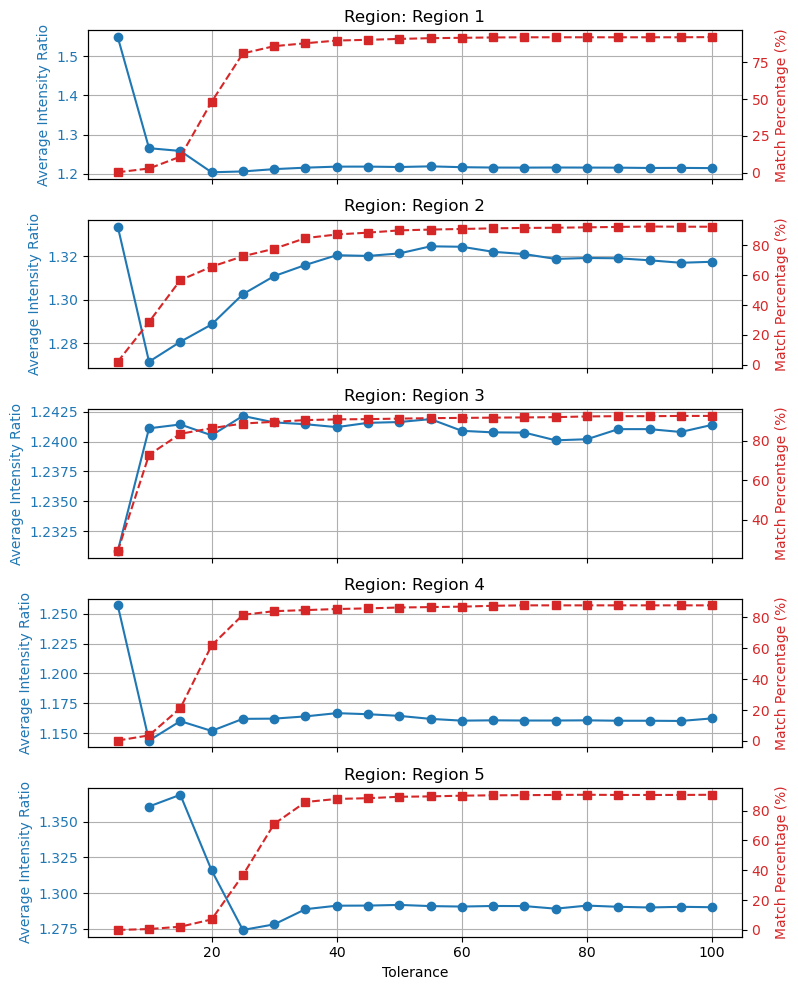

In [32]:
region_data = {}

for region in regions11.keys():
    if region in regions12:
        df1 = regions11[region]
        df2 = regions12[region]
        
        intensity_ratios = []
        match_percentages = []
        
        for tolerance in tolerances:
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                match_percentage = (num_matched / min(len(df1), len(df2))) * 100
            else:
                avg_intensity_ratio = np.nan
                match_percentage = 0  # No matches found
            
            intensity_ratios.append(avg_intensity_ratio)
            match_percentages.append(match_percentage)
        
        region_data[region] = {
            "intensity_ratios": intensity_ratios,
            "match_percentages": match_percentages
        }

# Create stacked vertical plots
num_regions = len(region_data)
fig, axes = plt.subplots(num_regions, 1, figsize=(8, 2 * num_regions), sharex=True)

# If only one region, convert axes to list for iteration
if num_regions == 1:
    axes = [axes]

for ax, (region, data) in zip(axes, region_data.items()):
    ax.set_ylabel("Average Intensity Ratio", color="tab:blue")
    ax.plot(tolerances, data["intensity_ratios"], marker='o', linestyle='-', color="tab:blue", label=f"Intensity Ratio")
    ax.tick_params(axis='y', labelcolor="tab:blue")
    
    # Create second y-axis for match percentage
    ax2 = ax.twinx()
    ax2.set_ylabel("Match Percentage (%)", color="tab:red")
    ax2.plot(tolerances, data["match_percentages"], marker='s', linestyle='--', color="tab:red", label=f"Match %")
    ax2.tick_params(axis='y', labelcolor="tab:red")
    
    ax.set_title(f"Region: {region}")
    ax.grid()

# Set common x-axis label
axes[-1].set_xlabel("Tolerance")

plt.tight_layout()
plt.show()

In [ ]:
sheet7 = '....'
regions13 = extract_regions(file1, sheet7)
regions14 = extract_regions(file2, sheet7)

for region in regions13.keys():
    if region in regions14:
        df1 = regions13[region]
        df2 = regions14[region]
        print(f"Region: {region} \n Entries in df1: {len(df1)}, Entries in df2: {len(df2)}")
        matched_df, num_matched = match_particles(regions13[region], regions14[region], tolerance=100.0)
        print(f"Matched particles: {num_matched}, Match % = {num_matched/min(len(df1), len(df2))*100:.2f}")
        print(f"Intensity ratio average = {np.mean(matched_df['intensity_ratio']):.3f}")
        print(matched_df.head())
        print("-" * 50)

Region: Region 1 
 Entries in df1: 688, Entries in df2: 714
Matched particles: 604, Match % = 87.79
Intensity ratio average = 1.419
    Centroid_X   Centroid_Y  intensity_ratio
0  2192.904632  1676.994560         1.254047
1   642.869673    22.274650         1.404329
2   942.982707    14.053667         1.355690
3  1568.975303    28.494612         1.613947
4  1832.450534    58.686595         1.249084
--------------------------------------------------
Region: Region 2 
 Entries in df1: 613, Entries in df2: 714
Matched particles: 557, Match % = 90.86
Intensity ratio average = 1.454
    Centroid_X   Centroid_Y  intensity_ratio
0  2175.896282  1636.455278         1.266484
1   410.269231    19.773656         1.492000
2   547.285542    16.770482         1.314560
3  1998.443020    30.338968         1.756124
4   179.422931    22.298405         1.198248
--------------------------------------------------


In [ ]:
matched_regions = {}

for region in regions13.keys():
    if region in regions14:
        df1 = regions13[region]
        df2 = regions14[region]
        matched_df, num_matched = match_particles(df1, df2, tolerance=100.0)
        matched_regions[region] = matched_df

output_file = f"matched_particles_{sheet7}.xlsx"

with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    all_regions = []
    
    for region, matched_df in matched_regions.items():
        matched_df = matched_df[['Centroid_X', 'Centroid_Y', 'intensity_ratio']]
        
        all_regions.append(matched_df)

    final_df = pd.concat(all_regions, axis=1)
    
    # Write to an Excel file (single sheet)
    final_df.to_excel(writer, sheet_name='Matched Data', index=False)

print(f"Exported matched data to {output_file}")

Exported matched data to matched_particles_c_4.26V.xlsx


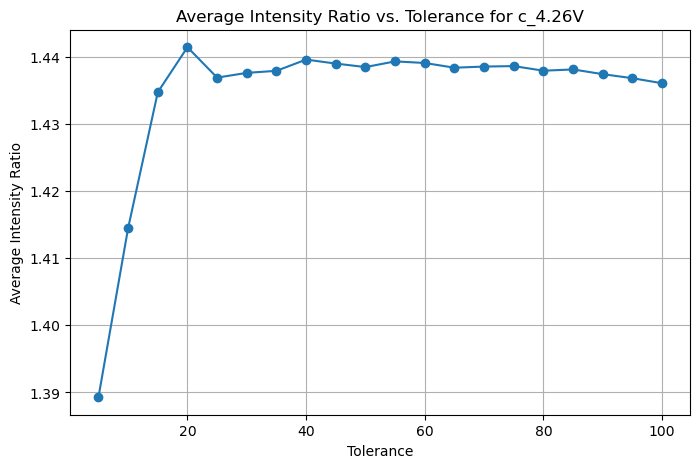

In [35]:
tolerances = np.linspace(5,100,20)

# Store results
tolerance_values = []
average_intensity_ratios = []

for tolerance in tolerances:
    total_intensity_ratios = []
    
    for region in regions13.keys():
        if region in regions14:
            df1 = regions13[region]
            df2 = regions14[region]
            
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                total_intensity_ratios.append(avg_intensity_ratio)

    if total_intensity_ratios:
        tolerance_values.append(tolerance)
        average_intensity_ratios.append(np.mean(total_intensity_ratios))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(tolerance_values, average_intensity_ratios, marker='o', linestyle='-')
plt.xlabel("Tolerance")
plt.ylabel("Average Intensity Ratio")
plt.title(f"Average Intensity Ratio vs. Tolerance for {sheet7}")
plt.grid()
plt.show()

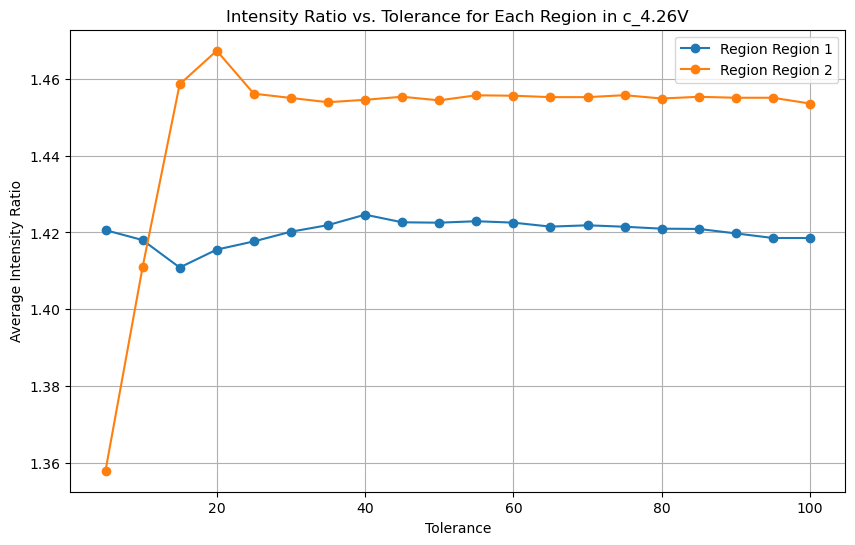

In [36]:
region_intensity_ratios = {}

for region in regions13.keys():
    if region in regions14:
        df1 = regions13[region]
        df2 = regions14[region]
        
        intensity_ratios = []
        
        for tolerance in tolerances:
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                intensity_ratios.append(avg_intensity_ratio)
            else:
                intensity_ratios.append(np.nan)  # Use NaN if no matches to avoid skewing results
        
        region_intensity_ratios[region] = intensity_ratios

# Plot intensity ratio for each region
plt.figure(figsize=(10, 6))

for region, intensity_ratios in region_intensity_ratios.items():
    plt.plot(tolerances, intensity_ratios, marker='o', linestyle='-', label=f"Region {region}")

plt.xlabel("Tolerance")
plt.ylabel("Average Intensity Ratio")
plt.title(f"Intensity Ratio vs. Tolerance for Each Region in {sheet7}")
plt.legend()
plt.grid()
plt.show()

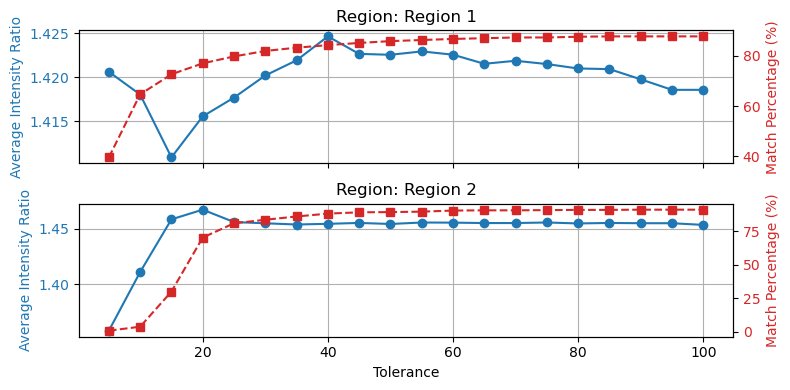

In [37]:
region_data = {}

for region in regions13.keys():
    if region in regions14:
        df1 = regions13[region]
        df2 = regions14[region]
        
        intensity_ratios = []
        match_percentages = []
        
        for tolerance in tolerances:
            matched_df, num_matched = match_particles(df1, df2, tolerance=tolerance)
            
            if num_matched > 0:
                avg_intensity_ratio = np.mean(matched_df["intensity_ratio"])
                match_percentage = (num_matched / min(len(df1), len(df2))) * 100
            else:
                avg_intensity_ratio = np.nan
                match_percentage = 0  # No matches found
            
            intensity_ratios.append(avg_intensity_ratio)
            match_percentages.append(match_percentage)
        
        region_data[region] = {
            "intensity_ratios": intensity_ratios,
            "match_percentages": match_percentages
        }

# Create stacked vertical plots
num_regions = len(region_data)
fig, axes = plt.subplots(num_regions, 1, figsize=(8, 2 * num_regions), sharex=True)

# If only one region, convert axes to list for iteration
if num_regions == 1:
    axes = [axes]

for ax, (region, data) in zip(axes, region_data.items()):
    ax.set_ylabel("Average Intensity Ratio", color="tab:blue")
    ax.plot(tolerances, data["intensity_ratios"], marker='o', linestyle='-', color="tab:blue", label=f"Intensity Ratio")
    ax.tick_params(axis='y', labelcolor="tab:blue")
    
    # Create second y-axis for match percentage
    ax2 = ax.twinx()
    ax2.set_ylabel("Match Percentage (%)", color="tab:red")
    ax2.plot(tolerances, data["match_percentages"], marker='s', linestyle='--', color="tab:red", label=f"Match %")
    ax2.tick_params(axis='y', labelcolor="tab:red")
    
    ax.set_title(f"Region: {region}")
    ax.grid()

# Set common x-axis label
axes[-1].set_xlabel("Tolerance")

plt.tight_layout()
plt.show()